# Toymodel
## Johannes Holst
### March 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from statistics import mean
import math
import pandas as pd

print('Libraries have been imported')

def gaussian(x, y, mux, muy, sigma):
    if np.sqrt((x - mux)**2 + (y - muy)**2) > 3 * sigma:
        return 0.
    else:
        return (1 / (2 * np.pi * sigma**2)) * np.e**((-(x - mux)**2 - (y - muy)**2) / (2 * sigma**2))

def overlap(x, y, b):
    if x < b / 2:
        return (1 / (1 - math.erf(b / (2**(3/2) * sigma1)))) * gaussian(x, y, b, 0, sigma1)
    else:
        return (1 / (1 - math.erf(b / (2**(3/2) * sigma1)))) * gaussian(x, y, 0, 0, sigma1)

def convolution(x, y, b):
    return gaussian(x, y, b, 0, np.sqrt(2) * sigma1)

def product(x, y, b):
    return gaussian(x, y, b/2, 0, sigma1 / np.sqrt(2))

print('Probability distributions have been defined')

NMPIdata = pd.read_csv('mpi.dat', delimiter = '	')
NCHdata = pd.read_csv('ch.dat', delimiter = '	')
NHdata = pd.read_csv('h.dat', delimiter = '	')

LHCdata = [[5.016525023561197, 0.023529411764705868],
          [7.023135033005673, 0.0303921568627451],
          [9.737960339901136, 0.03496732026143791],
          [14.105288007515583, 0.041503267973856214],
          [19.53493862130652, 0.04084967320261439],
          [21.54154863075099, 0.04215686274509804],
          [23.666194523103965, 0.04215686274509804]]

xexp = [i[0] for i in LHCdata]
yexp = [i[1] for i in LHCdata]

print('Data has been loaded')

Libraries have been imported
Probability distributions have been defined
Data has been loaded


In [2]:
def model(x, y, b):                 
    return overlap(x, y, b)         #Choice of probability density function

print('Model has been chosen')

sigma1 = 0.7                        #Sigma of the proton gaussian

xn = 101                            #Number of values on the x-axis
xr = -5.04, 5.04                    #Range of values of the x-axis
yn = xn                             #Number of values on the y-axis
yr = xr                             #Range of values on the y-axis

bn = 100                          #Number of values for the impact parameter
br = 0, 3 * sigma1                  #Range of values for the impact parameter

en = 1000                          #Number of events for each value of the impact parameter

print('Parameters have been set')

Model has been chosen
Parameters have been set


In [3]:
def eccPart(xList, yList, n):
    # Participant ecccentricity n squared
    num1 = 0.
    num2 = 0.
    denom = 0.
    sumw = 0.
    for x, y in zip(xList, yList):
        # Transform to polar
        r = np.sqrt(x*x + y*y)
        phi = np.arctan2(y,x)
        num1 += r**2 * np.cos(n * phi)
        num2 += r**2 * np.sin(n * phi)
        denom += r**2
        sumw += 1
    return ((num1/sumw)**2 + (num2/sumw)**2) / (denom / sumw)**2

In [4]:
xl = np.linspace(xr[0], xr[1], xn)
yl = np.linspace(yr[0], yr[1], yn)
bl = np.linspace(br[0], br[1], bn)

eps2lo = []
eps3lo = []
sc23lo = []
sclo = []
dNlo = []
v2lo = []
Slo = []
xyl = []
nMPIl = []

for x in xl:
    for y in yl:
        xyl.append((x, y))

for b in bl:
    pl = [overlap(xyl[i][0], xyl[i][1], b) for i in range(xn * yn)]
    eps2pl = []
    eps3pl = []
    
    Spl = []
    
    for i in range(len(NMPIdata)):
        if NMPIdata['xhigh'][i] > b:
            if NMPIdata['xlow'][i] <= b:
                nMPI = int(round(NMPIdata['val'][i]))
                nMPIl.append(nMPI)
                break
            else:
                pass
        else:
            pass
        
    for j in range(en):
        draw = random.choices(xyl, weights = pl, k = nMPI)
        
        drawx = [i[0] for i in draw]
        drawy = [i[1] for i in draw]
        
        x0 = mean(drawx)
        y0 = mean(drawy)
        
        drawx = [x - x0 for x in drawx]
        drawy = [y - y0 for y in drawy]

        drawx2 = [(i[0] - x0)**2 for i in draw]
        drawy2 = [(i[1] - y0)**2 for i in draw]
        drawxy = [(i[0] - x0) * (i[1] - y0) for i in draw]
        
        sigmax2 = mean(drawx2) - mean(drawx)**2
        sigmay2 = mean(drawy2) - mean(drawy)**2
        sigmaxy = mean(drawxy) - mean(drawx) * mean(drawy)
 
        eps2p = np.sqrt((sigmay2 - sigmax2)**2 + 4 * sigmaxy**2) / (sigmay2 + sigmax2)
        #eps2pl.append(eps2p)
        
        ee2 = eccPart(drawx, drawy, 2.)
        ee3 = eccPart(drawx, drawy, 3.)
        eps2pl.append(ee2)
        eps3pl.append(ee3)
        

        Sp = 4 * np.pi * np.sqrt(sigmax2 * sigmay2 - sigmaxy**2)
        Spl.append(Sp)
    
    S = mean(Spl)
    Slo.append(S)
    
    eps2p2l = eps2pl
    eps3p2l = eps3pl
    eps23p2l = [i*j for i,j in zip(eps2pl,eps3pl)]
    
    eps2 = np.sqrt(mean(eps2p2l))
    sc23 = (mean(eps23p2l) - mean(eps2p2l)*mean(eps3p2l)) / (mean(eps2p2l)*mean(eps3p2l))
    
    eps2lo.append(eps2)
    sc23lo.append(sc23)
    
    
    for i in range(len(NHdata)):
        if NHdata['xhigh'][i] > b:
            if NHdata['xlow'][i] <= b:
                v2lo.append((eps2 * 0.2) / (1 + 5.8 * S / NHdata['val'][i]))
                break
            else:
                pass
        else:
            pass
    
    for i in range(len(NCHdata)):
        if NCHdata['xhigh'][i] > b:
            if NCHdata['xlow'][i] <= b:
                dNlo.append(NCHdata['val'][i])
                break
            else:
                pass
        else:
            pass

print('All ' + str(bn * en) + ' events have been generated.')

<ipython-input-4-5b109a9d04e2>:66: RuntimeWarning: invalid value encountered in sqrt
  Sp = 4 * np.pi * np.sqrt(sigmax2 * sigmay2 - sigmaxy**2)
<ipython-input-4-5b109a9d04e2>:57: RuntimeWarning: invalid value encountered in double_scalars
  eps2p = np.sqrt((sigmay2 - sigmax2)**2 + 4 * sigmaxy**2) / (sigmay2 + sigmax2)
<ipython-input-3-aadddc9ae46c>:15: RuntimeWarning: invalid value encountered in double_scalars
  return ((num1/sumw)**2 + (num2/sumw)**2) / (denom / sumw)**2


All 100000 events have been generated.


In [5]:
xl = np.linspace(xr[0], xr[1], xn)
yl = np.linspace(yr[0], yr[1], yn)
bl = np.linspace(br[0], br[1], bn)

eps2lp = []
sc23lp = []
dNlp = []
v2lp = []
Slpwo = []
xyl = []
nMPIl = []

for x in xl:
    for y in yl:
        xyl.append((x, y))

for b in bl:
    pl = [product(xyl[i][0], xyl[i][1], b) for i in range(xn * yn)]
    eps2pl = []
    eps3pl = []

    Spl = []
    
    for i in range(len(NMPIdata)):
        if NMPIdata['xhigh'][i] > b:
            if NMPIdata['xlow'][i] <= b:
                nMPI = int(round(NMPIdata['val'][i]))
                nMPIl.append(nMPI)
                break
            else:
                pass
        else:
            pass
        
    for j in range(en):
        draw = random.choices(xyl, weights = pl, k = nMPI)
        
        drawx = [i[0] for i in draw]
        drawy = [i[1] for i in draw]
        
        x0 = mean(drawx)
        y0 = mean(drawy)
        
        drawx = [x - x0 for x in drawx]
        drawy = [y - y0 for y in drawy]

        drawx2 = [(i[0] - x0)**2 for i in draw]
        drawy2 = [(i[1] - y0)**2 for i in draw]
        drawxy = [(i[0] - x0) * (i[1] - y0) for i in draw]
        
        sigmax2 = mean(drawx2) - mean(drawx)**2
        sigmay2 = mean(drawy2) - mean(drawy)**2
        sigmaxy = mean(drawxy) - mean(drawx) * mean(drawy)
        
        eps2p = np.sqrt((sigmay2 - sigmax2)**2 + 4 * sigmaxy**2) / (sigmay2 + sigmax2)
        #eps2pl.append(eps2p)
        
        ee2 = eccPart(drawx, drawy, 2.)
        ee3 = eccPart(drawx, drawy, 3.)
        eps2pl.append(ee2)
        eps3pl.append(ee3)
        

        Sp = 4 * np.pi * np.sqrt(sigmax2 * sigmay2 - sigmaxy**2)
        Spl.append(Sp)
    
    S = mean(Spl)
    Slpwo.append(S)
    
    eps2p2l = eps2pl
    eps3p2l =  eps3pl
    eps23p2l = [i*j for i,j in zip(eps2pl,eps3pl)]
    
    eps2 = np.sqrt(mean(eps2p2l))
    sc23 = (mean(eps23p2l) - mean(eps2p2l)*mean(eps3p2l)) / (mean(eps2p2l)*mean(eps3p2l))
    
    eps2lp.append(eps2)
    sc23lp.append(sc23)
    
    
    for i in range(len(NHdata)):
        if NHdata['xhigh'][i] > b:
            if NHdata['xlow'][i] <= b:
                v2lp.append((eps2 * 0.2) / (1 + 5.8 * S / NHdata['val'][i]))
                break
            else:
                pass
        else:
            pass
    
    for i in range(len(NCHdata)):
        if NCHdata['xhigh'][i] > b:
            if NCHdata['xlow'][i] <= b:
                dNlp.append(NCHdata['val'][i])
                break
            else:
                pass
        else:
            pass

print('All ' + str(bn * en) + ' events have been generated.')

<ipython-input-5-063b009638ff>:64: RuntimeWarning: invalid value encountered in sqrt
  Sp = 4 * np.pi * np.sqrt(sigmax2 * sigmay2 - sigmaxy**2)
<ipython-input-5-063b009638ff>:55: RuntimeWarning: invalid value encountered in double_scalars
  eps2p = np.sqrt((sigmay2 - sigmax2)**2 + 4 * sigmaxy**2) / (sigmay2 + sigmax2)
<ipython-input-3-aadddc9ae46c>:15: RuntimeWarning: invalid value encountered in double_scalars
  return ((num1/sumw)**2 + (num2/sumw)**2) / (denom / sumw)**2


All 100000 events have been generated.


In [6]:
xl = np.linspace(xr[0], xr[1], xn)
yl = np.linspace(yr[0], yr[1], yn)
bl = np.linspace(br[0], br[1], bn)

eps2lc = []
sc23lc = []
dNlc = []
v2lc = []
Slc = []
xyl = []
nMPIl = []

for x in xl:
    for y in yl:
        xyl.append((x, y))

for b in bl:
    pl = [convolution(xyl[i][0], xyl[i][1], b) for i in range(xn * yn)]
    eps2pl = []
    Spl = []
    
    for i in range(len(NMPIdata)):
        if NMPIdata['xhigh'][i] > b:
            if NMPIdata['xlow'][i] <= b:
                nMPI = int(round(NMPIdata['val'][i]))
                nMPIl.append(nMPI)
                break
            else:
                pass
        else:
            pass
        
    for j in range(en):
        draw = random.choices(xyl, weights = pl, k = nMPI)
        
        drawx = [i[0] for i in draw]
        drawy = [i[1] for i in draw]
        
        x0 = mean(drawx)
        y0 = mean(drawy)
        
        drawx = [x - x0 for x in drawx]
        drawy = [y - y0 for y in drawy]

        drawx2 = [(i[0] - x0)**2 for i in draw]
        drawy2 = [(i[1] - y0)**2 for i in draw]
        drawxy = [(i[0] - x0) * (i[1] - y0) for i in draw]
        
        sigmax2 = mean(drawx2) - mean(drawx)**2
        sigmay2 = mean(drawy2) - mean(drawy)**2
        sigmaxy = mean(drawxy) - mean(drawx) * mean(drawy)
        
        eps2p = np.sqrt((sigmay2 - sigmax2)**2 + 4 * sigmaxy**2) / (sigmay2 + sigmax2)
        #eps2pl.append(eps2p)
        ee2 = eccPart(drawx, drawy, 2.)
        ee3 = eccPart(drawx, drawy, 3.)
        eps2pl.append(ee2)
        eps3pl.append(ee3)

        Sp = 4 * np.pi * np.sqrt(sigmax2 * sigmay2 - sigmaxy**2)
        Spl.append(Sp)
    
    S = mean(Spl)
    Slc.append(S)
    
    eps2p2l = eps2pl
    eps3p2l = eps3pl
    eps23p2l = [i*j for i,j in zip(eps2pl,eps3pl)]
    
    eps2 = np.sqrt(mean(eps2p2l))
    sc23 = (mean(eps23p2l) - mean(eps2p2l)*mean(eps3p2l)) / (mean(eps2p2l)*mean(eps3p2l))
    
    eps2lc.append(eps2)
    sc23lc.append(sc23)
    
    for i in range(len(NHdata)):
        if NHdata['xhigh'][i] > b:
            if NHdata['xlow'][i] <= b:
                v2lc.append((eps2 * 0.2) / (1 + 5.8 * S / NHdata['val'][i]))
                break
            else:
                pass
        else:
            pass
    
    for i in range(len(NCHdata)):
        if NCHdata['xhigh'][i] > b:
            if NCHdata['xlow'][i] <= b:
                dNlc.append(NCHdata['val'][i])
                break
            else:
                pass
        else:
            pass

print('All ' + str(bn * en) + ' events have been generated.')

<ipython-input-6-ec443e876218>:60: RuntimeWarning: invalid value encountered in sqrt
  Sp = 4 * np.pi * np.sqrt(sigmax2 * sigmay2 - sigmaxy**2)
<ipython-input-6-ec443e876218>:53: RuntimeWarning: invalid value encountered in double_scalars
  eps2p = np.sqrt((sigmay2 - sigmax2)**2 + 4 * sigmaxy**2) / (sigmay2 + sigmax2)
<ipython-input-3-aadddc9ae46c>:15: RuntimeWarning: invalid value encountered in double_scalars
  return ((num1/sumw)**2 + (num2/sumw)**2) / (denom / sumw)**2


All 100000 events have been generated.


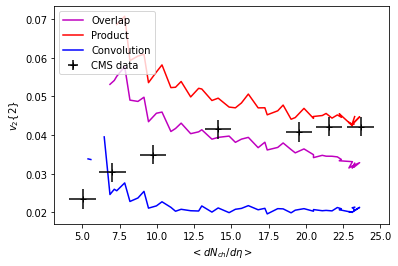

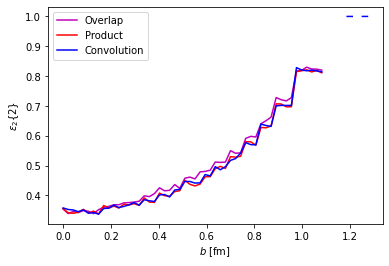

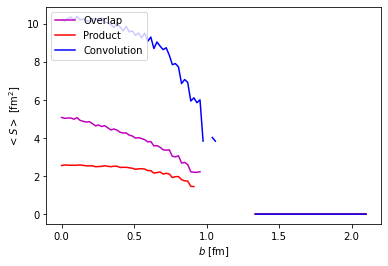

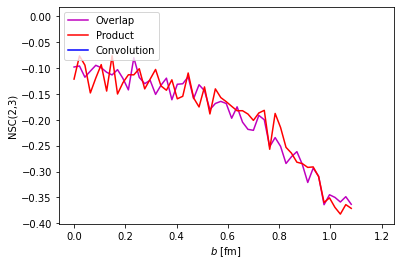

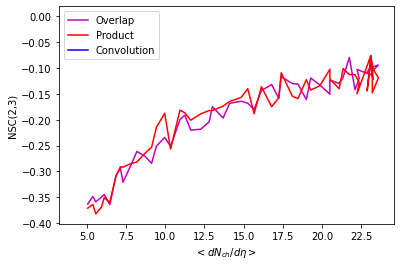

In [7]:
fig0=plt.figure(0)
plt.ylabel('$v_2\{2\}$')
plt.xlabel('$<dN_{ch}/d\eta>$')
plt.plot(dNlo, v2lo, 'm-', label = "Overlap")
plt.plot(dNlp, v2lp, 'r-', label = "Product")
plt.plot(dNlc, v2lc, 'b-', label = "Convolution")
plt.errorbar(xexp, yexp, xerr = 0.8858, yerr = 0.0025, fmt = 'k+', label = "CMS data")
plt.legend(loc='upper left')
fig0.savefig("mpidependv2.pdf", bbox_inches='tight')

fig1=plt.figure(1)
plt.ylabel('$\epsilon_2\{2\}$')
plt.xlabel('$b$ [fm]')
plt.plot(bl, eps2lo, 'm-', label = "Overlap")
plt.plot(bl, eps2lp, 'r-', label = "Product")
plt.plot(bl, eps2lc, 'b-', label = "Convolution")
plt.legend(loc='upper left')
fig1.savefig("mpidependeps.pdf", bbox_inches='tight')

fig2=plt.figure(2)
plt.ylabel('$<S>$ [fm$^2$]')
plt.xlabel('$b$ [fm]')
plt.plot(bl, Slo, 'm-', label = "Overlap")
plt.plot(bl, Slpwo, 'r-', label = "Product")
plt.plot(bl, Slc, 'b-', label = "Convolution")
plt.legend(loc='upper left')
fig2.savefig("mpidependss.pdf", bbox_inches='tight')

fig3=plt.figure(3)

plt.ylabel('NSC(2,3)')
plt.xlabel('$b$ [fm]')

plt.plot(bl, sc23lo, 'm-', label = "Overlap")
plt.plot(bl, sc23lp, 'r-', label = "Product")
plt.plot(bl, sc23lc, 'b-', label = "Convolution")
plt.legend(loc='upper left')

fig3=plt.figure(4)

plt.ylabel('NSC(2,3)')
plt.xlabel('$<dN_{ch}/d\eta>$')

plt.plot(dNlo, sc23lo, 'm-', label = "Overlap")
plt.plot(dNlp, sc23lp, 'r-', label = "Product")
plt.plot(dNlc, sc23lc, 'b-', label = "Convolution")
plt.legend(loc='upper left')



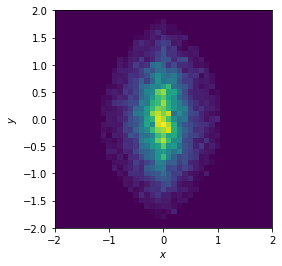

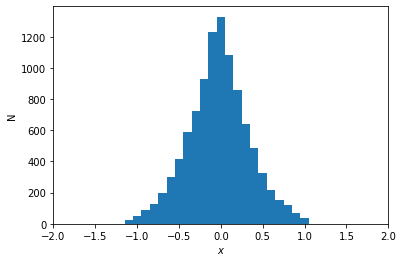

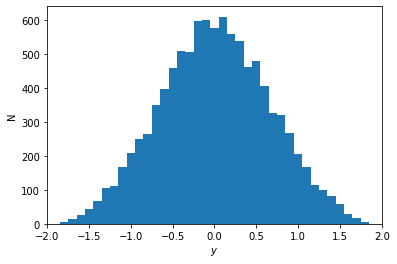

In [8]:
b1 = 2.8 * sigma1
histN = 10000
histxr = -2, 2
histyr = histxr

xl = np.linspace(xr[0], xr[1], xn)
yl = np.linspace(yr[0], yr[1], yn)

xyl = []

for x in xl:
    for y in yl:
        xyl.append((x, y))

p1l = [model(xyl[i][0], xyl[i][1], b1) for i in range(xn * yn)]

draw = random.choices(xyl, weights = p1l, k = histN)

drawx = [i[0] for i in draw]
drawy = [i[1] for i in draw]

x0 = mean(drawx)
y0 = mean(drawy)

drawx = [x - x0 for x in drawx]
drawy = [y - y0 for y in drawy]


t=plt.figure(4)
plt.hist2d(drawx, drawy, bins = [xn, yn], range = [xr, yr])
plt.ylabel('$y$')
plt.xlabel('$x$')
plt.xlim(histxr) 
plt.ylim(histyr) 
plt.gca().set_aspect('equal')

plt.figure(5)
plt.hist(drawx, bins = xn, range = xr)
plt.ylabel('N')
plt.xlabel('$x$')
plt.xlim(histxr) 

plt.figure(6)
plt.hist(drawy, bins = yn, range = yr)
plt.ylabel('N')
plt.xlabel('$y$')
plt.xlim(histyr) 

t.savefig("nompidepend.pdf", bbox_inches='tight')